In [1]:
import numpy as np

from scipy.stats import norm

np.random.seed(0)

from utils import traceplot, acfplot

# Generalised Normal Distribution

**Parameters:**

-   $\mu$: Location parameter.
-   $\alpha > 0$: Scale parameter.
-   $\beta > 0$: Shape parameter.

**PDF:**
$$f(x) \propto \exp \left\{- \left( \frac{|x - \mu|}{\alpha} \right)^\beta \right\}$$

**Log PDF:**
$$\log f(x) \propto - \left(\frac{|x - \mu|}{\alpha}\right)^\beta$$

**First derivative of log PDF:**
$$\frac{\text{d}}{\text{d} x} \log f(x) = - \frac{\beta}{\alpha^\beta} \left|x - \mu\right|^{\beta - 1} \text{sgn}(x - \mu)$$

**Second derivative of log PDF:**
$$\frac{\text{d}^2}{\text{d} x^2} \log f(x) = - \frac{\beta (\beta - 1)}{\alpha^\beta} \left|x - \mu\right|^{\beta - 2}$$

**Third derivative of log PDF:**
$$\frac{\text{d}^3}{\text{d} x^3} \log f(x) = - \frac{\beta (\beta - 1) (\beta - 2)}{\alpha^\beta} \left|x - \mu\right|^{\beta - 3} \, \text{sgn}(x - \mu)$$


In [2]:
def logpi_gnd(x, mu=0, alpha=1, beta=2):
    return - (np.abs(x - mu) / alpha)**beta

def first_logpi_gnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - (beta / alpha**beta) * np.abs(diff)**(beta-1) * np.sign(diff)

def second_logpi_gnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - ((beta * (beta-1)) / alpha**beta) * np.abs(diff)**(beta-2)

def third_logpi_gnd(x, mu=1, alpha=1, beta=2):
    diff = x - mu
    return - ((beta * (beta-1) * (beta-2)) / alpha**beta) * np.abs(diff)**(beta-3) * np.sign(diff)

# Smoothed Generalised Normal Distribution

**Parameters:**

-   $\mu$: Location parameter.
-   $\alpha > 0$: Scale parameter.
-   $\beta > 0$: Shape parameter.
-   $\epsilon = 1e-3$: Small term for numerical stability.

**PDF:**

$$
f(x) \propto \exp \left\{- \left( \frac{\sqrt{\epsilon^2 + (x - \mu)^2}}{\alpha} \right)^\beta \right\}
$$

**Log PDF:**

$$
\log f(x) \propto - \left( \frac{\sqrt{\epsilon^2 + (x - \mu)^2}}{\alpha} \right)^\beta
$$

**First derivative of log PDF:**

$$
\frac{\mathrm{d}}{\mathrm{d} x} \log f(x) = - \frac{\beta}{\alpha^\beta}
(x - \mu)
\left[ \epsilon^2 + (x - \mu)^2 \right]^\frac{\beta - 2}{2}
$$

**Second derivative of log PDF:**

$$
\frac{\mathrm{d}^2}{\mathrm{d} x^2} \log f(x) = - \frac{\beta}{\alpha^\beta}
\left[ \epsilon^2 + (x - \mu)^2 \right]^{\frac{\beta - 4}{2}}
\left[ (\beta - 1)(x - \mu)^2 + \epsilon^2 \right]
$$

**Third derivative of log PDF:**

$$
\frac{\mathrm{d}^3}{\mathrm{d} x^3} \log f(x) = - \frac{\beta (\beta - 2)}{\alpha^\beta}
(x - \mu)
\left[ \epsilon^2 + (x - \mu)^2 \right]^{\frac{\beta - 6}{2}}
\left[ (\beta - 1)(x - \mu)^2 + 3 \epsilon^2 \right]
$$


In [3]:
EPSILON = 1

def logpi_sgnd(x, mu=0, alpha=1, beta=2):
    return - (np.sqrt(EPSILON* + (x - mu)**2) / alpha)**beta

def first_logpi_sgnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - (beta / alpha**beta) * diff * (EPSILON + diff**2)**((beta-2)/2)

def second_logpi_sgnd(x, mu=0, alpha=1, beta=2):
    diff = x - mu
    return - (beta / alpha**beta) * (EPSILON + diff**2)**((beta-4)/2) * ((beta-1) * diff**2 + EPSILON)

def third_logpi_sgnd(x, mu=1, alpha=1, beta=2):
    diff = x - mu
    return - ((beta * (beta-2)) / alpha**beta) * diff * (EPSILON + diff**2)**((beta-6)/2) * ((beta-1) * diff**2 + 3*EPSILON)

# MALA

$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} \nabla \log \pi(x),
    \ h
\right)
$$


In [4]:
def mala_proposal(x, first_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * first_logpi_x + z


def mala_logq_ratio(x, y, first_logpi_x, first_logpi_y, step_size):
    log_xy = norm.logpdf(y, loc=(x + (1/2) * (step_size**2) * first_logpi_x), scale=step_size)
    log_yx = norm.logpdf(x, loc=(y + (1/2) * (step_size**2) * first_logpi_y), scale=step_size)
    
    return log_yx - log_xy


def mala(logpi, first_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)

    for i in range(0, n_iter):
        first_logpi_x = first_logpi(x, **kwargs)
        
        # Generate a proposal state
        y = mala_proposal(x, first_logpi_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        first_logpi_y = first_logpi(y, **kwargs)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mala_logq_ratio(x, y, first_logpi_x, first_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

In [5]:
N_ITER = 10000
X_INIT = [0]

In [6]:
mala_samples1, accept_rate = mala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=1, 
    step_size=1.2
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.8211


In [7]:
mala_samples2, accept_rate = mala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=2, 
    step_size=0.3
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9935


In [8]:
mala_samples3, accept_rate = mala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=3, 
    step_size=0.9
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.7186


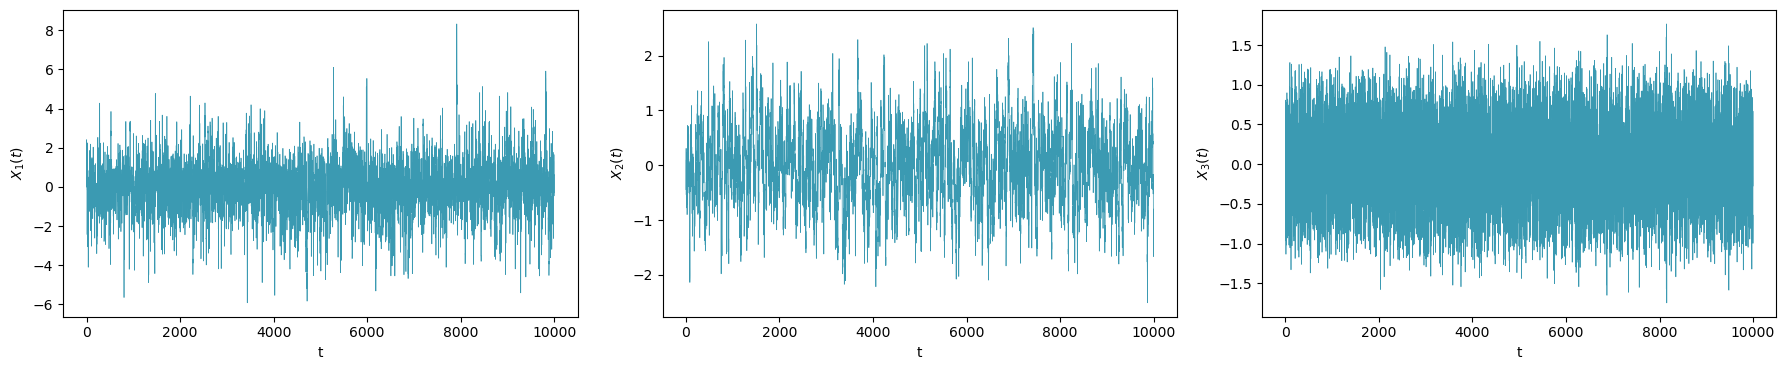

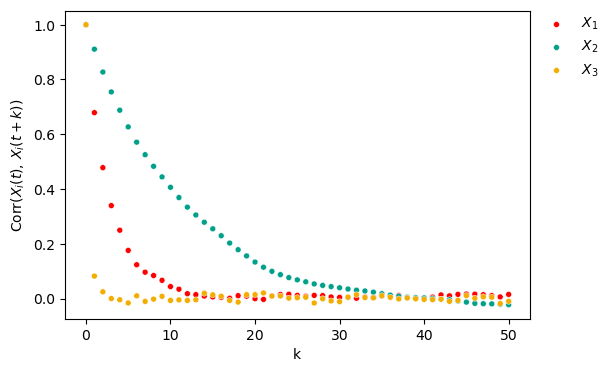

In [9]:
mala_samples = np.vstack([mala_samples1, mala_samples2, mala_samples3])
traceplot(mala_samples, overlay=False, n_col=3)
acfplot(mala_samples)

# MMALA


$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} A(x) \nabla \log \pi(x) + h \Gamma(x),
    \ h A(x)
\right)
$$

$$A(x) = \left( - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \right)^{-1}$$

$$\Gamma(x) = - \frac{1}{2} \left( - \frac{\text{d}^2}{\text{d} x^2} \log f(x) \right)^{-2} \frac{\text{d}^3}{\text{d} x^3} \log f(x)$$


In [10]:
def mmala_proposal(x, first_logpi_x, A_x, Gamma_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) * np.sqrt(A_x)

    return x + (1/2) * (step_size**2) * A_x * first_logpi_x + (step_size**2) * Gamma_x + z


def mmala_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y, Gamma_x, Gamma_y, step_size):
    loc_xy = x + (1/2) * (step_size**2) * A_x * first_logpi_x + (step_size**2) * Gamma_x
    loc_yx = y + (1/2) * (step_size**2) * A_y * first_logpi_y + (step_size**2) * Gamma_y

    scale_xy = step_size * np.sqrt(A_x)
    scale_yx = step_size * np.sqrt(A_y)

    log_xy = norm.logpdf(y, loc=loc_xy, scale=scale_xy)
    log_yx = norm.logpdf(x, loc=loc_yx, scale=scale_yx)
    
    return log_yx - log_xy


def mmala(logpi, first_logpi, second_logpi, third_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)

    for i in range(0, n_iter):
        first_logpi_x = first_logpi(x, **kwargs)
        second_logpi_x = second_logpi(x, **kwargs)
        A_x = 1 / (-second_logpi_x) 
        Gamma_x = - (1/2) * (A_x**2) * np.sign(second_logpi_x) * third_logpi(x, **kwargs)
        # Gamma_x = - (1/2) * (A_x**2) * third_logpi(x, **kwargs)
        
        # Generate a proposal state
        y = mmala_proposal(x, first_logpi_x, A_x, Gamma_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        
        first_logpi_y = first_logpi(y, **kwargs)
        second_logpi_y = second_logpi(y, **kwargs)
        A_y = 1 / (-second_logpi_y) 
        Gamma_y = - (1/2) * (A_y**2) * np.sign(second_logpi_y) * third_logpi(y, **kwargs)
        # Gamma_y = - (1/2) * (A_y**2) * third_logpi(y, **kwargs)

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + mmala_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y, Gamma_x, Gamma_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

In [11]:
mmla_samples1, accept_rate = mmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    third_logpi=third_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=1, 
    step_size=0.0002
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9998


In [12]:
mmala_samples2, accept_rate = mmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    third_logpi=third_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=2, 
    step_size=0.2
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9993


In [13]:
mmala_samples3, accept_rate = mmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    third_logpi=third_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=3, 
    step_size=8e-6
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 1.0


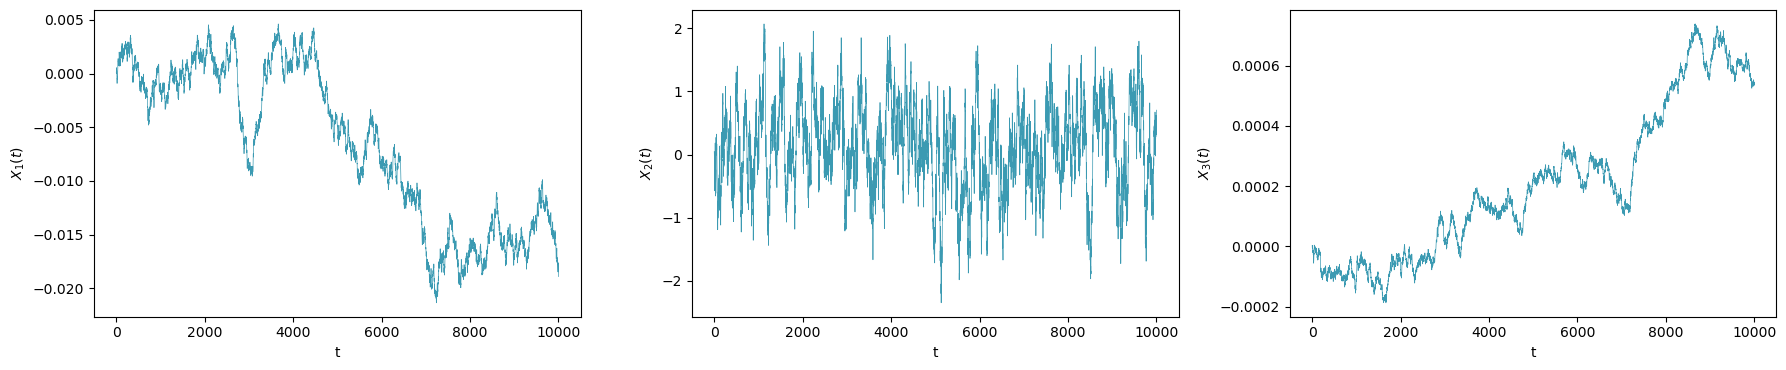

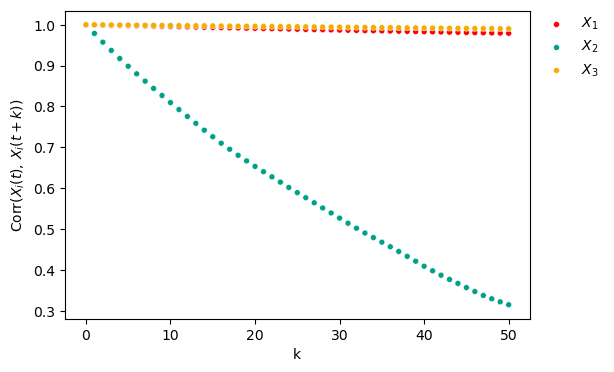

In [14]:
mmala_samples = np.vstack([mmla_samples1, mmala_samples2, mmala_samples3])
traceplot(mmala_samples, overlay=False, n_col=3)
acfplot(mmala_samples)

# SMMALA

$$
y \sim \mathcal{N} \left(
    x + \frac{h}{2} A(x) \nabla \log \pi(x),
    \ h A(x)
\right)
$$


In [15]:
def smmala_proposal(x, first_logpi_x, A_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) 

    return x + (1/2) * (step_size**2) * A_x * first_logpi_x + z * np.sqrt(A_x)


def smmala_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y, step_size):
    loc_xy = x + (1/2) * (step_size**2) * A_x * first_logpi_x
    loc_yx = y + (1/2) * (step_size**2) * A_y * first_logpi_y

    scale_xy = step_size * np.sqrt(A_x)
    scale_yx = step_size * np.sqrt(A_y)

    log_xy = norm.logpdf(y, loc=loc_xy, scale=scale_xy)
    log_yx = norm.logpdf(x, loc=loc_yx, scale=scale_yx)
    
    return log_yx - log_xy


def smmala(logpi, first_logpi, second_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)

    for i in range(0, n_iter):
        first_logpi_x = first_logpi(x, **kwargs)
        A_x = 1 / (-second_logpi(x, **kwargs))
        
        # Generate a proposal state
        y = smmala_proposal(x, first_logpi_x, A_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        first_logpi_y = first_logpi(y, **kwargs)
        A_y = 1 / (-second_logpi(y, **kwargs))

        # Calculate log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + smmala_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store current state
        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

In [25]:
smmala_samples1, accept_rate = smmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT,
    beta=1, 
    step_size=0.08
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9458


In [17]:
smmala_samples2, accept_rate = smmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT,
    beta=2, 
    step_size=0.5
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9889


In [18]:
smmala_samples3, accept_rate = smmala(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT,
    beta=3, 
    step_size=0.5
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.9324


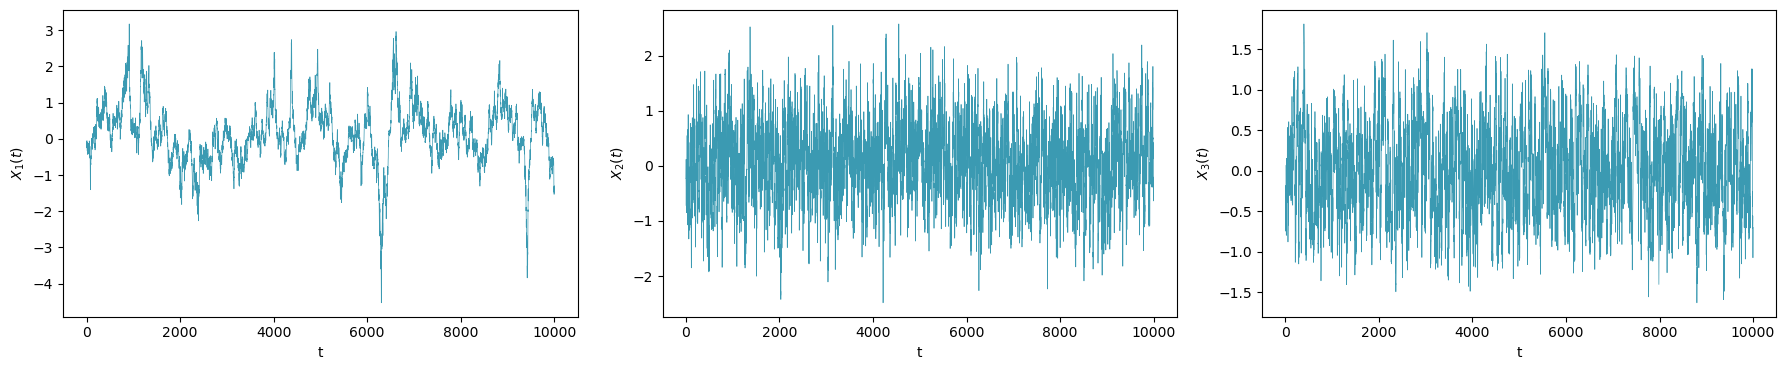

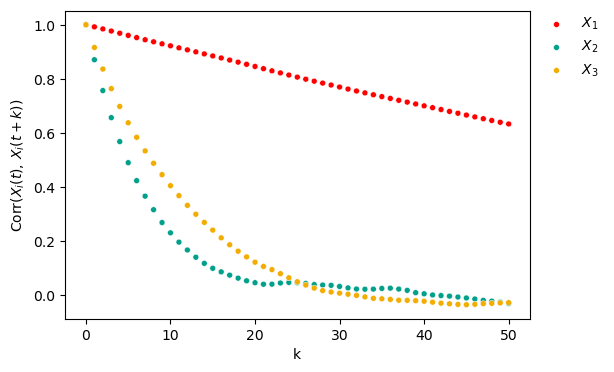

In [19]:
smmala_samples = np.vstack([smmala_samples1, smmala_samples2, smmala_samples3])
traceplot(smmala_samples, overlay=False, n_col=3)
acfplot(smmala_samples)

# SMBarker


In [83]:
def smbarker_proposal(x, first_logpi_x, A_x, step_size=1):
    # z ~ Normal(mean = sigma, sd = 0.1 * sigma)
    z = np.random.normal(loc=step_size, scale=0.3*step_size) # TODO check
    
    # Acceptance probability for each component: 1 / (1 + exp(-grad * z))
    acceptance_prob = 1.0 / (1.0 + np.exp(- z * (first_logpi_x @ A_x)))
    
    # b is either +1 or -1 depending on a uniform random draw
    b = 2 * (np.random.uniform(size=1) < acceptance_prob) - 1

    # # Magnitude
    # z = step_size * np.random.normal(size=len(x), scale=1)

    # # Direction
    # threshold = 1 / (1 + np.exp(- z * (first_logpi_x @ A_x)))
    # b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 
    # z *= b

    return x + A_x @ (b * z)


def smbarker_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y):
    z_xy = (1 / A_x) @ (x - y)
    z_yx = (1 / A_y) @ (y - x)

    logq_xy = - np.log1p(np.exp(z_xy * (first_logpi_x @ A_x)))
    logq_yx = - np.log1p(np.exp(z_yx * (first_logpi_y @ A_y)))

    return np.sum(logq_yx - logq_xy)


def smbarker(logpi, first_logpi, second_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # Matrix to store sampled values from chain (#components, #iterations)
    X = np.empty((len(x_init), n_iter+1))

    # Counter for accepted proposals
    accepted = 0

    # Log of target distribution at current state
    logpi_x = logpi(x, **kwargs)
    
    for i in range(0, n_iter):
        first_logpi_x = first_logpi(x, **kwargs)
        A_x = 1 / (-second_logpi(x, **kwargs))

        # Generate a proposal state
        y = smbarker_proposal(x, first_logpi_x, A_x, step_size)

        logpi_y = logpi(y, **kwargs)
        first_logpi_y = first_logpi(y, **kwargs)
        A_y = 1 / (-second_logpi(y, **kwargs))

        # Calculate log preconditioned Barker acceptance rate
        logq_ratio = smbarker_logq_ratio(x, y, first_logpi_x, first_logpi_y, A_x, A_y)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store current state
        X[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate 

Acceptance rate: 0.4351


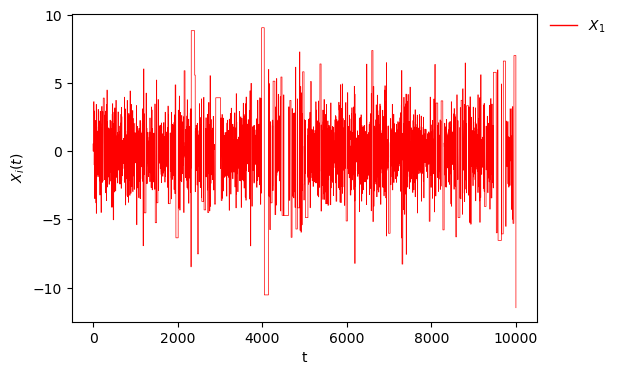

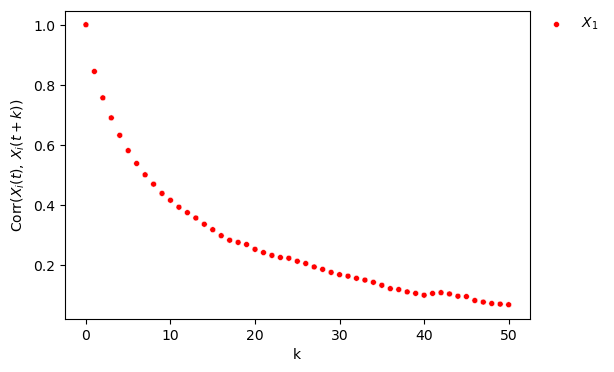

In [89]:
smbarker_samples1, accept_rate = smbarker(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT, 
    beta=1.1, 
    step_size=0.7
)

print(f'Acceptance rate: {accept_rate}')
traceplot(smbarker_samples1)
acfplot(smbarker_samples1)

Acceptance rate: 0.2928


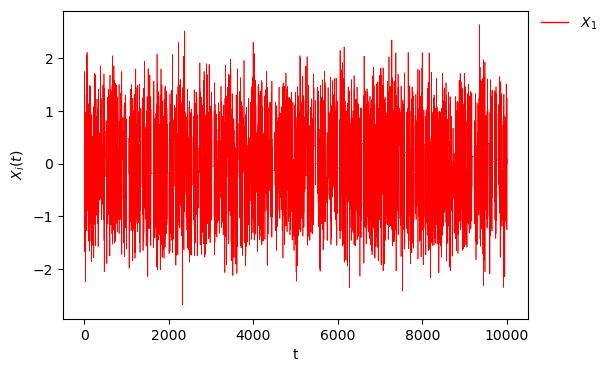

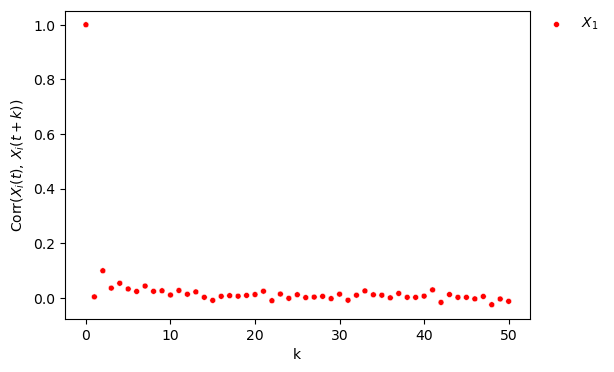

In [100]:
smbarker_samples2, accept_rate = smbarker(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT,
    beta=2, 
    step_size=4.5
)

print(f'Acceptance rate: {accept_rate}')
traceplot(smbarker_samples2)
acfplot(smbarker_samples2)

In [104]:
smbarker_samples3, accept_rate = smbarker(
    logpi=logpi_sgnd,
    first_logpi=first_logpi_sgnd,
    second_logpi=second_logpi_sgnd,
    n_iter=N_ITER, 
    x_init=X_INIT,
    beta=3, 
    step_size=4.5
)

print(f'Acceptance rate: {accept_rate}')

Acceptance rate: 0.5515


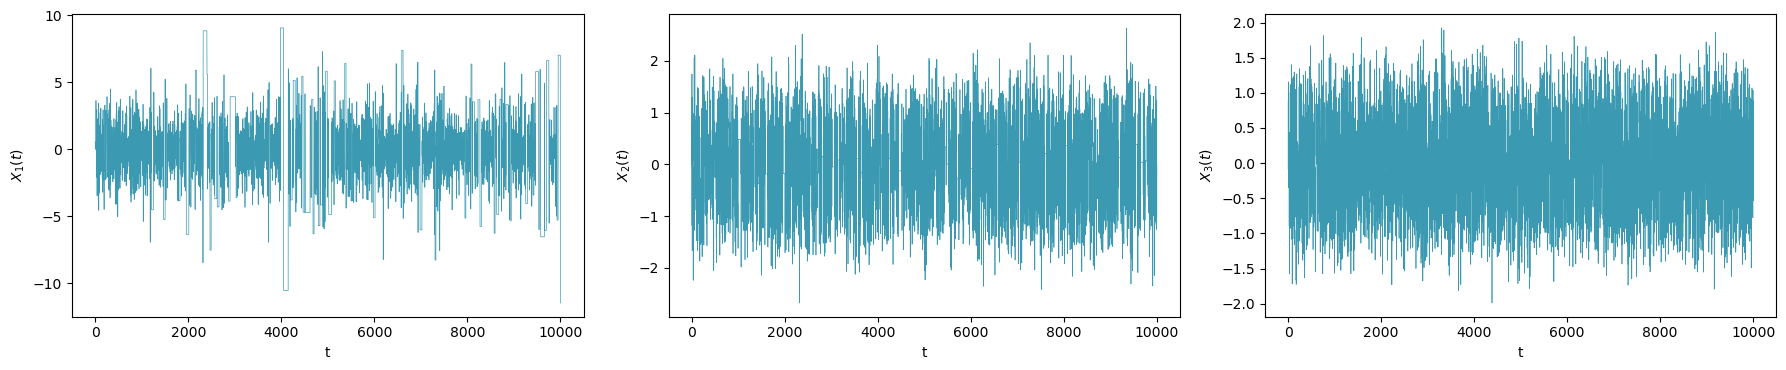

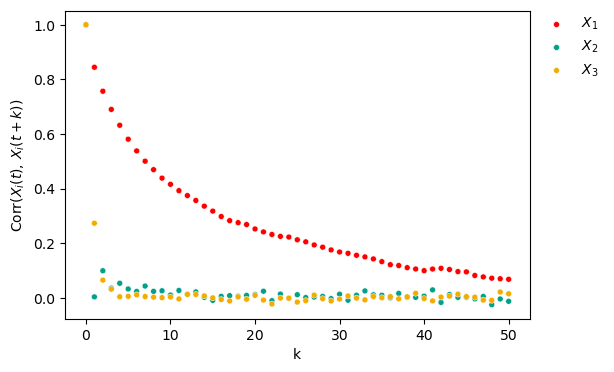

In [105]:
smbarker_samples = np.vstack([smbarker_samples1, smbarker_samples2, smbarker_samples3])
traceplot(smbarker_samples, overlay=False, n_col=3)
acfplot(smbarker_samples)